In [6]:
# --- Single-image classification in a notebook (DenseNet121-based) ---

import io
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets

import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model


# Optional: quieter TF logs
tf.get_logger().setLevel('ERROR')


# Instantiate the classifier
classifier = load_model("classifier.h5")

def prepare_image_for_model(file_bytes, target_size=(64, 64)):
    """Load, RGB-convert, resize, and preprocess for DenseNet121."""
    img = Image.open(io.BytesIO(file_bytes)).convert("RGB")
    img_resized = img.resize(target_size, Image.BILINEAR)
    arr = np.asarray(img_resized, dtype=np.float32)
    arr = preprocess_input(arr)          # ImageNet-style normalization
    batch = np.expand_dims(arr, axis=0)  # Add batch dimension
    return img, batch  # return original PIL image for display, and preprocessed batch

def classify_uploaded_image(file_bytes):
    img_display, batch = prepare_image_for_model(file_bytes)
    preds = classifier.predict(batch, verbose=0)[0]  # shape (2,)
    pred_idx = int(np.argmax(preds))
    pred_label = CLASS_NAMES[pred_idx]
    return img_display, pred_label, preds

# ---- Simple notebook UI with ipywidgets ----
uploader = widgets.FileUpload(accept='image/*', multiple=False)
run_btn = widgets.Button(description='Classify Image', button_style='primary')
out = widgets.Output()

def on_click_run(_):
    with out:
        clear_output()
        if not uploader.value:
            print("Please upload one image first.")
            return

        files = uploader.value
        # Handle ipywidgets versions: dict (old), tuple/list (new)
        if isinstance(files, dict):
            file_info = next(iter(files.values()))
        elif isinstance(files, (tuple, list)):
            file_info = files[0]
        else:
            raise TypeError(f"Unsupported FileUpload.value type: {type(files)}")

        file_bytes = file_info["content"]

        img, label, probs = classify_uploaded_image(file_bytes)

        print("Prediction:", label)
        print(f"Probabilities -> {CLASS_NAMES[0]}: {probs[0]:.4f}, {CLASS_NAMES[1]}: {probs[1]:.4f}")
        display(img)

run_btn.on_click(on_click_run)

display(widgets.VBox([widgets.HTML("<b>Upload one image, then click Classify:</b>"),
                       uploader, run_btn, out]))




In [4]:
classifier.save("classifier.keras")

In [10]:
# Load the entire model (architecture + weights)
classifier = load_model("/Users/sambra/Documents/GitHub/sam_based_fungal_app/classifier.keras")
path_input = "/Users/sambra/Documents/GitHub/sporecounting/Segmented_Images/original/Wt 8h OH RB2_C00_ORG_ (1)_7.png"


Prediction: Germinated
Ungerminated: 0.0001
Germinated: 0.9999


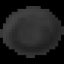

In [11]:
# --- Single-image classification from a file path (DenseNet121-based) ---

from pathlib import Path
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import load_model

# ==== Set this ====
IMAGE_PATH = "/Users/sambra/Documents/GitHub/sporecounting/Segmented_Images/original/Wt 8h OH RB2_C00_ORG_ (1)_7.png"   # <-- put your image path here
MODEL_PATH = "/Users/sambra/Documents/GitHub/sam_based_fungal_app/classifier.keras"       # change if needed
CLASS_NAMES = ["Ungerminated", "Germinated"]  # adjust to your classes

# Optional: quieter TF logs
tf.get_logger().setLevel("ERROR")

# Load model
classifier = load_model(MODEL_PATH)

def prepare_image_from_path(path: str, target_size=(64, 64)):
    """Load file path -> RGB -> resize -> preprocess -> return (PIL image, batch)."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Image path not found: {p}")

    img = Image.open(p).convert("RGB")
    img_resized = img.resize(target_size, Image.BILINEAR)
    arr = np.asarray(img_resized, dtype=np.float32)
    arr = preprocess_input(arr)                    # ImageNet-style normalization
    batch = np.expand_dims(arr, axis=0)           # (1, H, W, 3)
    return img, batch

def classify_image_path(path: str):
    img_display, batch = prepare_image_from_path(path)
    preds = classifier.predict(batch, verbose=0)[0]   # shape (num_classes,)
    pred_idx = int(np.argmax(preds))
    pred_label = CLASS_NAMES[pred_idx]
    return img_display, pred_label, preds

# Run classification
img, label, probs = classify_image_path(IMAGE_PATH)
print("Prediction:", label)
for i, name in enumerate(CLASS_NAMES):
    print(f"{name}: {probs[i]:.4f}")
display(img)


In [3]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /private/var/folders/xz/wnmpfwfd79bbx_lqntg_fwgc0000gp/T/pip-req-build-f27j5sif
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /private/var/folders/xz/wnmpfwfd79bbx_lqntg_fwgc0000gp/T/pip-req-build-f27j5sif
  Resolved https://www.github.com/mouseland/cellpose.git to commit 0a3de7b6420470c1d1ccf33ba6f4bc821fe532cc
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.15.3-cp310-cp310-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached tifffile-2025.5.10-py3-none-any.whl.metadata (31 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fastremap-1.17.6-cp310-cp310-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached imagecodecs-2025.3.30-cp310-cp310-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached roifile-2025.5.10-py3-none-any.whl.metadata (5.9 kB)
  Using cached fill_v

In [20]:
from cellpose.models import MODEL_DIR
from cellpose.models import get_user_models
from pathlib import Path
from PIL import Image

print("MODEL_DIR:", MODEL_DIR)
print("Built-ins (v4):", ["cpsam"])
print("GUI-added models:", get_user_models())  # from gui_models.txt
print("Files in MODEL_DIR:", [p.name for p in pathlib.Path(MODEL_DIR).glob("*")])

MODEL_DIR: /Users/sambra/.cellpose/models
Built-ins (v4): ['cpsam']
GUI-added models: []
Files in MODEL_DIR: ['cyto2torch_0', 'cpsam', 'size_cyto2torch_0.npy', 'yeast_BF_cp3', 'nucleitorch_0', 'size_cytotorch_0.npy', 'deblur_cyto3', 'cyto3', 'yeast_PhC_cp3', 'denoise_cyto3', 'size_cyto3.npy', 'cyto2_cp3', 'cytotorch_0']


In [21]:
from cellpose import models, core, io, plot
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-11-11 00:02:00,753 [INFO] WRITING LOG OUTPUT TO /Users/sambra/.cellpose/run.log
2025-11-11 00:02:00,754 [INFO] 
cellpose version: 	3.1.1.2 
platform:       	darwin 
python version: 	3.10.18 
torch version:  	2.5.1
2025-11-11 00:02:00,758 [INFO] ** TORCH MPS version installed and working. **
2025-11-11 00:02:00,762 [INFO] ** TORCH MPS version installed and working. **
2025-11-11 00:02:00,762 [INFO] >>>> using GPU (MPS)
2025-11-11 00:02:00,879 [INFO] >>>> no model weights loaded


In [24]:
#convert everyting to rgb
from pathlib import Path


dir = Path("/Users/sambra/Documents/GitHub/sam_based_fungal_app/images")
files = [f for f in dir.glob("*.tif") if "_seg" not in f.name and "_flows" not in f.name]
if not files: raise FileNotFoundError("no .tif images found")

for f in files:
    with Image.open(f) as im:
        im.convert("RGB").save(f)

In [25]:
# *** change to your google drive folder path ***
dir = "/Users/sambra/Documents/GitHub/sam_based_fungal_app/Images"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

14 images in folder:
A4_pheromone_plate_2-1313.tif
A4_pheromone_plate_2-1818.tif
A4_pheromone_plate_2-2929.tif
Bb_pheromone_tube2-2270.tif
Bb_pheromone_tube2-2371.tif
Bb_pheromone_tube2-2573.tif
Bb_pheromone_tube2-2674.tif
Bb_pheromone_tube2-2775.tif
Bb_pheromone_tube2-2977.tif
Bb_pheromone_tube2-3078.tif
Bb_pheromone_tube2-3179.tif
Bb_pheromone_tube2-3482.tif
Bb_pheromone_tube2-3583.tif
Bb_pheromone_tube2-3886.tif


your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:02,958 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


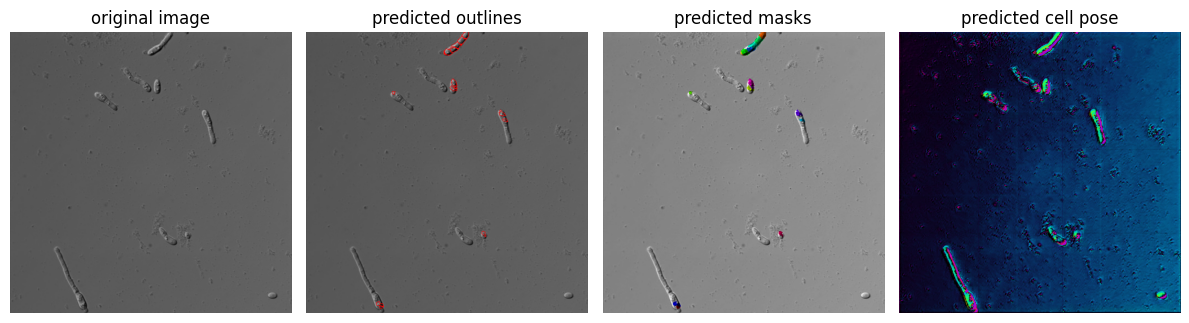

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:03,428 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


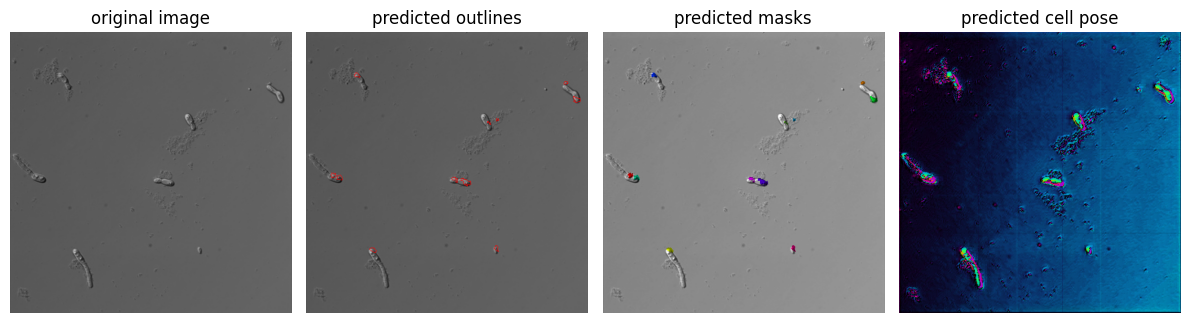

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:03,856 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


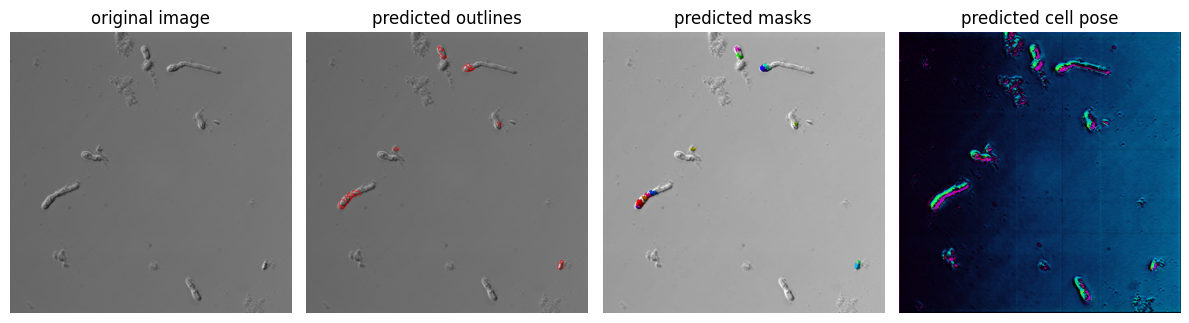

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:04,292 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


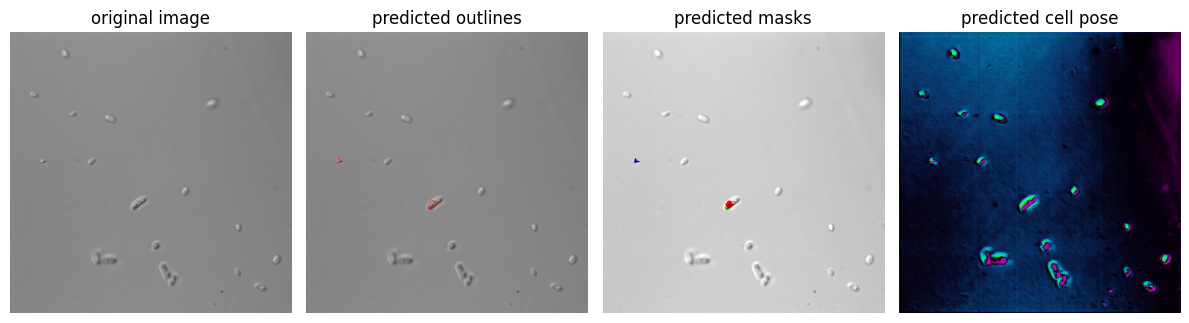

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:04,829 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


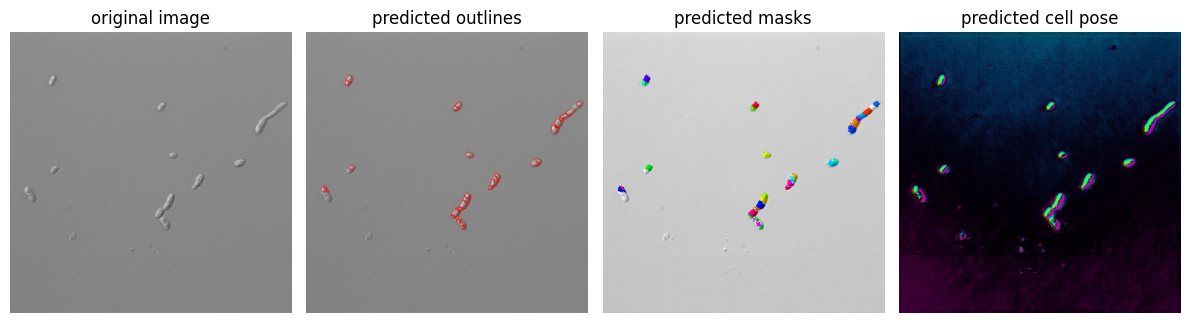

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:05,280 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


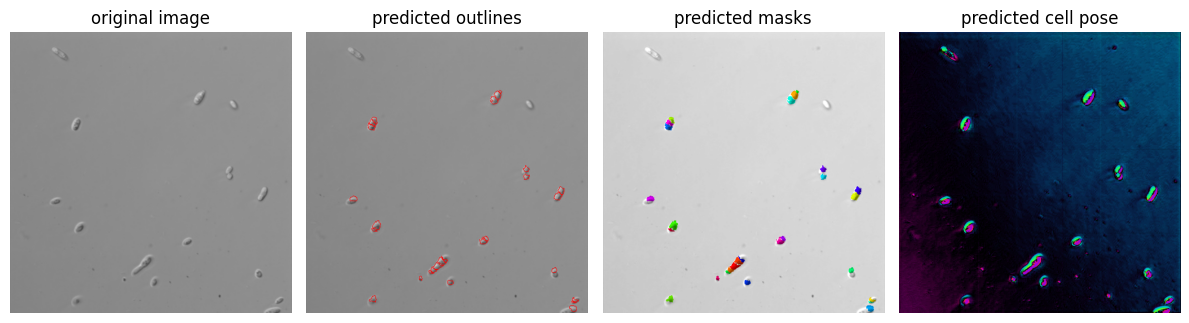

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:05,720 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


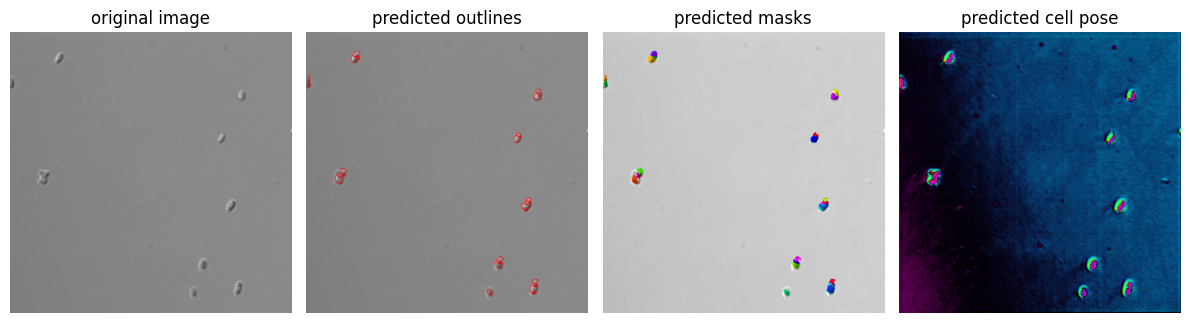

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:06,146 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


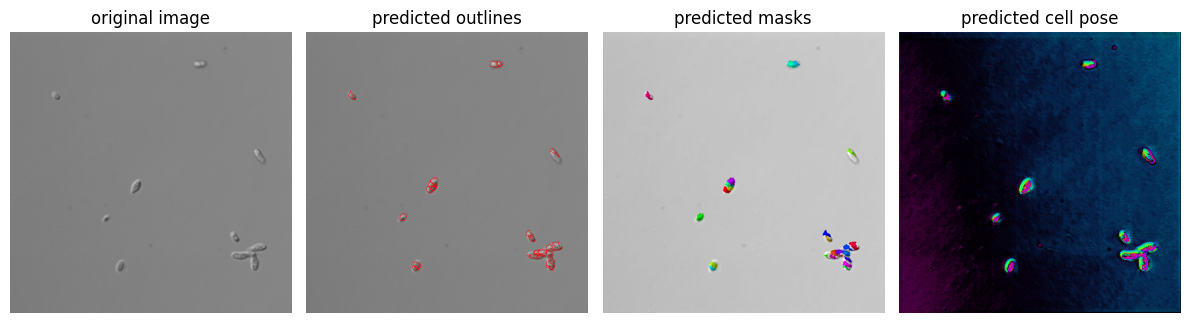

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:06,578 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


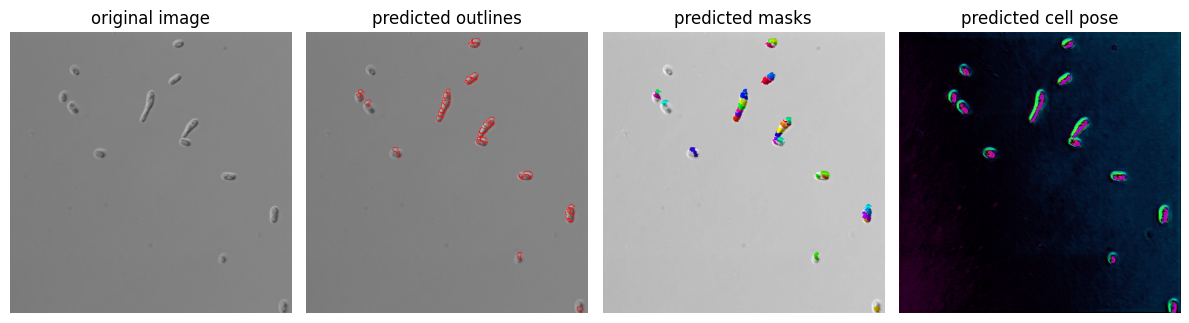

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:07,024 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


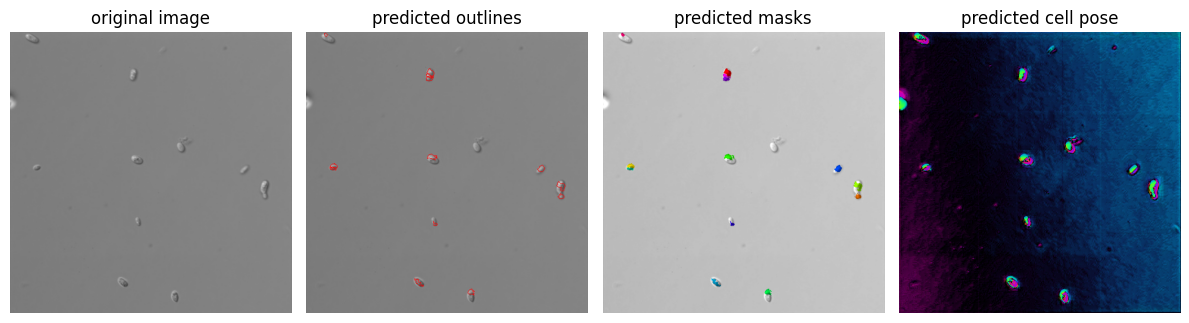

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:07,446 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


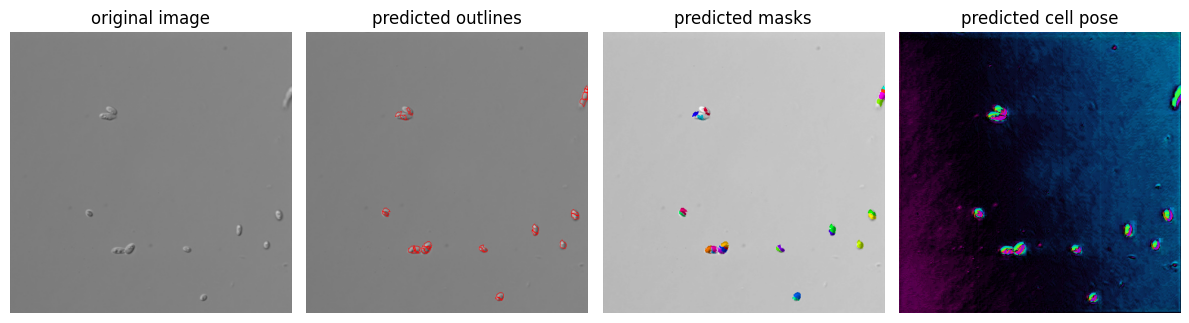

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:07,870 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


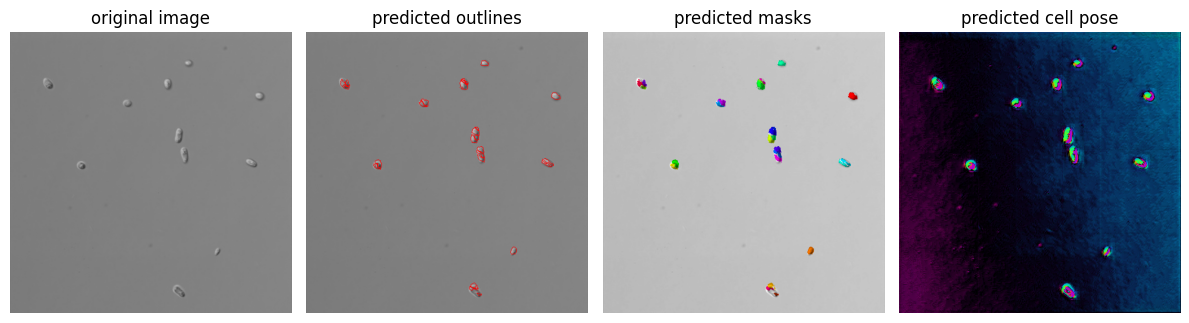

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:08,287 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


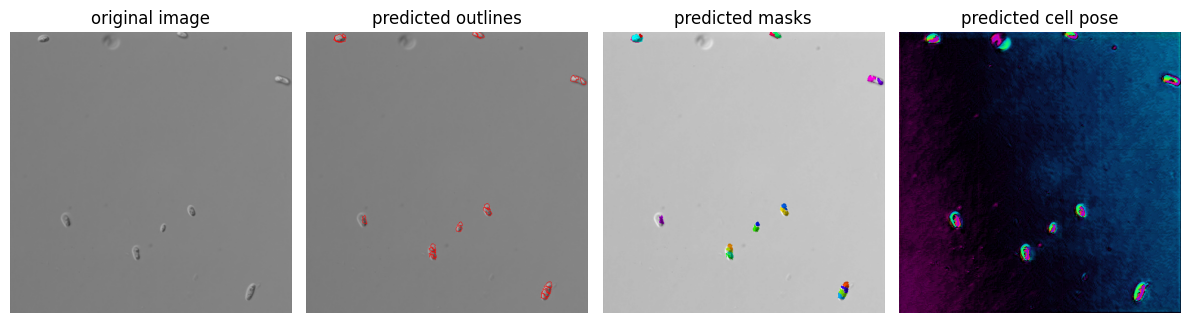

your image has shape: (512, 512, 3). Assuming channel dimension is last with 3 channels
2025-11-11 10:13:08,701 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing


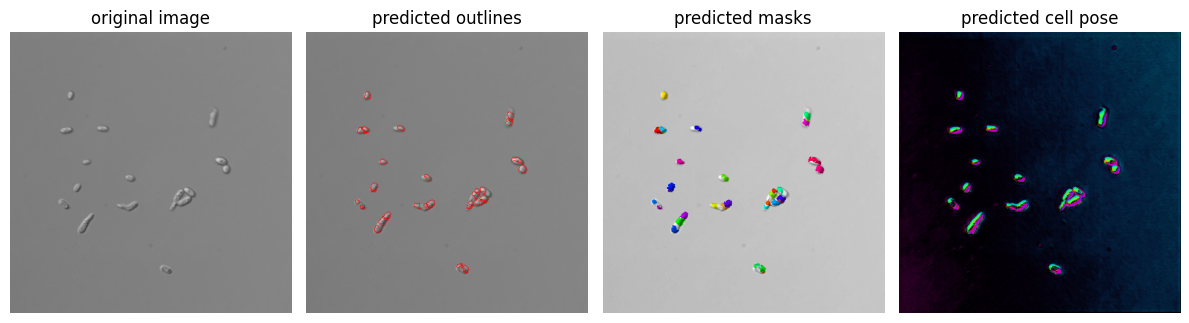

In [47]:
for img in files:
  img = io.imread(img)

  print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

  first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
  second_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
  third_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]

  selected_channels = []
  for i, c in enumerate([first_channel, second_channel, third_channel]):
    if c == 'None':
      continue
    if int(c) > img.shape[-1]:
      assert False, 'invalid channel index, must have index greater or equal to the number of channels'
    if c != 'None':
      selected_channels.append(int(c))

  img_selected_channels = np.zeros_like(img)
  img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]

  flow_threshold = 0.0
  cellprob_threshold = 0.0
  tile_norm_blocksize = 0

  masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                    normalize={"tile_norm_blocksize": tile_norm_blocksize})

  fig = plt.figure(figsize=(12,5))
  plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
  plt.tight_layout()
  plt.show()

In [31]:
imgs = [io.imread(files[i]) for i in trange(len(files))]
masks_ext = ".png" if image_ext == ".png" else ".tif"

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

100%|██████████| 22/22 [00:00<00:00, 1210.80it/s]

running cellpose-SAM
2025-09-27 15:06:51,727 [INFO] 0%|          | 0/22 [00:00<?, ?it/s]


2025-09-27 15:06:57,525 [INFO] No cell pixels found.
2025-09-27 15:08:13,645 [INFO] 59%|#####9    | 13/22 [01:21<00:45,  5.06s/it]
2025-09-27 15:08:22,348 [INFO] No cell pixels found.
2025-09-27 15:08:42,428 [INFO] 100%|##########| 22/22 [01:50<00:00,  5.03s/it]
saving masks


100%|██████████| 22/22 [00:00<00:00, 514.35it/s]


In [69]:
from natsort import natsorted
from pathlib import Path

%cd /Users/sambra/Documents/GitHub/sam_based_fungal_app/sampose_20

train_dir = "train"
test_dir = "test"

masks_ext = "_seg.npy"

/Users/sambra/Documents/GitHub/sam_based_fungal_app/sampose_20


In [ ]:
from cellpose import train

model_name = "new_model"

# default training params
n_epochs = 100
learning_rate = 1e-5
weight_decay = 0.1
batch_size = 1

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter=masks_ext)
train_data, train_labels, _, test_data, test_labels, _ = output
# (not passing test data into function to speed up training)

new_model_path, train_losses, test_losses = train.train_seg(model.net,
                                                            train_data=train_data,
                                                            train_labels=train_labels,
                                                            batch_size=batch_size,
                                                            n_epochs=n_epochs,
                                                            learning_rate=learning_rate,
                                                            weight_decay=weight_decay,
                                                            nimg_per_epoch=max(2, len(train_data)), # can change this
                                                            model_name=model_name)

2025-09-27 16:20:17,139 [INFO] not all flows are present, running flow generation for all images
2025-09-27 16:20:17,252 [INFO] 8 / 8 images in train folder have labels
2025-09-27 16:20:17,256 [INFO] not all flows are present, running flow generation for all images
2025-09-27 16:20:17,569 [INFO] 22 / 22 images in test folder have labels
2025-09-27 16:20:17,619 [INFO] computing flows for labels


100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

2025-09-27 16:20:19,045 [INFO] >>> computing diameters



100%|██████████| 8/8 [00:00<00:00, 194.17it/s]

2025-09-27 16:20:19,087 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2025-09-27 16:20:19,164 [INFO] >>> n_epochs=100, n_train=8, n_test=None
2025-09-27 16:20:19,165 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-09-27 16:20:19,170 [INFO] >>> saving model to /Users/sambra/Documents/GitHub/sam_based_fungal_app/sampose_20/models/new_model


2025-09-27 16:35:59,465 [INFO] 0, train_loss=0.0468, test_loss=0.0000, LR=0.000000, time 940.29s
